<a href="https://colab.research.google.com/github/pfclustering/Clu/blob/master/GraphEcalClustering_colab_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install uproot

     |████████████████████████████████| 290 kB 32.1 MB/s 


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
#!ls '/content/gdrive/My Drive/Colab Notebooks'
!mkdir '/content/gdrive/My Drive/Colab Notebooks/plots_wOverlap'
#!ls '/content/gdrive/My Drive/Colab Notebooks/plots'
global plotpath
plotpath = '/content/gdrive/My Drive/Colab Notebooks/plots_wOverlap'

Mounted at /content/gdrive
mkdir: cannot create directory ‘/content/gdrive/My Drive/Colab Notebooks/plots_wOverlap’: File exists


In [ ]:
#@title Imports  { form-width: "30%" }
%tensorflow_version 1.x  # For Google Colab only.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import uproot
import numpy as np
import graph_nets as gn
from graph_nets.demos import models

import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from collections import OrderedDict
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

import collections
import itertools
import time
import pickle

import tensorflow as tf

useNodes = False
nFrac = 3

log_every_n_evts = 10
seed = 2
rand = np.random.RandomState(seed=seed)
tf.set_random_seed(seed)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # For Google Colab only.`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Functions

In [ ]:
#@title Pre-processing functions  { form-width: "30%" }
def check(nevts, files):
  '''check that files can be opened correctly and that there are enough entries'''
  tot_entries = 0

  for fn in files:
    try:
      tot_entries += uproot.open(fn)['recosimdumper']['caloTree'].numentries
    except:
      print('file f={} may not exist or does not have tree=recosimdumper/caloTree'.format(fn))

  if tot_entries < nevts:
    print('Chosen number of events is too large, using max_nevts=', tot_entries)
    return tot_entries
 
  else:
    return nevts 

def getDataFrames(nevts,files):
  '''
  creates lists of pandas dataframes for sim and reco
  ''' 
  simdfs = []
  recodfs = []

#  # wrong way of reading arrays I would say... 
#  for inev in range(0,nevts):
#    simdf = pd.DataFrame({ 'energy': uproot.lazyarray(files, 'recosimdumper/caloTree', 'simHit_energy')[inev],
#                           'ieta'  : uproot.lazyarray(files, 'recosimdumper/caloTree', 'simHit_ieta')[inev],
#                           'iphi'  : uproot.lazyarray(files, 'recosimdumper/caloTree', 'simHit_iphi')[inev],
#                           'icalo' : uproot.lazyarray(files, 'recosimdumper/caloTree', 'simHit_icP')[inev],
#                         })  
#    simdfs.append(simdf)
#
#    recodf = pd.DataFrame({'energy': uproot.lazyarray(files, 'recosimdumper/caloTree', 'pfRecHit_energy')[inev],
#                           'ieta'  : uproot.lazyarray(files, 'recosimdumper/caloTree', 'pfRecHit_ieta')[inev],
#                           'iphi'  : uproot.lazyarray(files, 'recosimdumper/caloTree', 'pfRecHit_iphi')[inev],
#                           })
#    recodfs.append(recodf)

  events = uproot.open(files[0])['recosimdumper']['caloTree'] # assume there is only one file
  for inev in range(0,nevts):
    if inev % log_every_n_evts == 0: print('Info in getDataFrames(), event=', inev)
    
    # energyCalo => column of the df
    energy = events.array('simHit_energy')[inev]
    energyCalo = events.array('caloParticle_simEnergy')[inev]
    completion = -99*np.ones((energy.shape[0]-energyCalo.shape[0],)) 
    energyCalo_filled = np.concatenate((energyCalo,completion),axis=0)

    simdf = pd.DataFrame({ 'energy': energy,
                           'ieta': events.array('simHit_ieta')[inev], 
                           'iphi': events.array('simHit_iphi')[inev], 
                           'icalo': events.array('simHit_icP')[inev],
                           'energyCalo': energyCalo_filled, 
                         })  

    simdfs.append(simdf)

    recodf = pd.DataFrame({'energy': events.array('pfRecHit_energy')[inev],
                           'ieta': events.array('pfRecHit_ieta')[inev],
                           'iphi': events.array('pfRecHit_iphi')[inev],
                           'eta':  events.array('pfRecHit_eta')[inev],
                           })
    recodfs.append(recodf)

  return simdfs,recodfs


def to_one_hot(indices, max_value, axis=-1):
  '''
  generate one-hot encoding for indices (integer labels), with number of classes given by max_value
  '''
  one_hot = np.eye(max_value)[indices]
  if axis not in (-1, one_hot.ndim):
    one_hot = np.moveaxis(one_hot, -1, axis)
  return one_hot

def OLD_getDictsFromDFs(recodfs,simdfs,rand,doSelection=False,matricesSel=[]):
  '''
  Starting from reco and sim information in pandas dataframes, creates a graph structure for reco and true clusters, with the format specified below,
  optionally performs a selection of possible edges, based on a matrix

     nodes_0 = [[10.0, 2, 3],  # Node 0  # energy, ieta, iphi
                [11.3, 0, 2],  # Node 1
                [34.3, 2, 1],  # Node 2
                [13.0, 3, 3],  # Node 3
                [14.0, 4, 4]]  # Node 4 
     
      for reco:
      edges_0 = [[1.2],  # Edge 0  #  distance between the nodes
              [0.123],  # Edge 1
              [0.321],  # Edge 2
              [1.44],   # Edge 3
              [2.41],   # Edge 4
              [1.23]]   # Edge 5
     for true: 
      edges_0 = [[1., 0], # Edge 1  # one-hot encoding: true it nodes belong to the same caloparticle, false otherwise
                 [0., 1], # Edge 2
               ...]

     senders_0 = [0,  # Index of the sender node for edge 0
             1,  # Index of the sender node for edge 1
             1,  # Index of the sender node for edge 2
             2,  # Index of the sender node for edge 3
             2,  # Index of the sender node for edge 4
             3]  # Index of the sender node for edge 5

     receivers_0 = [1,  # Index of the receiver node for edge 0
               2,  # Index of the receiver node for edge 1
               3,  # Index of the receiver node for edge 2
               0,  # Index of the receiver node for edge 3
               3,  # Index of the receiver node for edge 4
               4]  # Index of the receiver node for edge 5 
  '''

  reco_dicts = []
  true_dicts = []

  assert(len(recodfs)==len(simdfs))

  for inev,recodf in enumerate(recodfs):
    
    if inev % log_every_n_evts == 0: print('Info getDictsFromDFs(), event=', inev)
    simdf = simdfs[inev]

    #define nodes, edges and globals
    nodes = []
    edges = []
    true_edges = []
    senders = []
    receivers = []
    #globals = []

    # straight conversion from pd to list of lists
    nodes = recodf.values.tolist() 
    
    # create edges between every node with every other node, in both directions
    for i,inode in recodf.iterrows():
      for j,jnode in recodf.iterrows():
        
        # if true, do KNN selection on the reco graph, i.e. only consider edges between nearest neighbours
        if doSelection: 
          #print('debug matrix =', matricesSel[inev][(i,j)])
          if matricesSel[inev][(i,j)]==0: continue 
        
        # do not create a self-edge
        if i==j: continue 

        # only consider edges in one direction
        #if j<i: continue 

        ## set edges for reco graph, 
        #score = rand.rand(1).tolist()  # randomness should be repeatable here too
        ## set edges for reco graph, DR distance between nodes
        distance = np.sqrt(np.square([inode['eta']-jnode['eta'], (inode['iphi']-jnode['iphi'])*np.pi/180]).sum())
        edges.append([distance]) # []
        senders.append(i)
        receivers.append(j)

        ## set edges for true graph
        # find indices of i,j reco ndoes in the sim df 
        index_i_sim = simdf[(simdf['ieta'] == inode['ieta']) & (simdf['iphi'] == inode['iphi'])].index.values
        index_j_sim = simdf[(simdf['ieta'] == jnode['ieta']) & (simdf['iphi'] == jnode['iphi'])].index.values

        true_class = [0] # must be integer
        
        chosen_i_icalo = -1
        chosen_j_icalo = -1

        if len(index_i_sim)==0:
          # this node does not exist in the sim graph, true edge = 0
          chosen_i_icalo = -99  
        elif len(index_i_sim)==1:
          # one match in the sim graph, easy choice of the i_icalo
          chosen_i_icalo == simdf.at[index_i_sim[0], 'icalo']
        else:
          # find the icalo with the higest energy in the specified 
          smalldf = simdf.iloc[index_i_sim] 
          chosen_i_icalo = smalldf.loc[smalldf['energy'].idxmax(), 'icalo']

        # repeat the logic with j
        if len(index_j_sim)==0:
          chosen_j_icalo = 99 
        elif len(index_j_sim)==1:
          chosen_j_icalo == simdf.at[index_j_sim[0], 'icalo']
        else:
          smalldf = simdf.iloc[index_j_sim]
          chosen_j_icalo = smalldf.loc[smalldf['energy'].idxmax(), 'icalo']

        # do the hits belong to the same caloparticle ?
        if chosen_i_icalo == chosen_j_icalo:
          true_class = [1] # otherwise keep it 0

        one_hot_label = list(to_one_hot(true_class,2)[0])
        true_edges.append(one_hot_label) # []


    reco_dict = {
      'globals': [1.],
      'nodes': nodes,
      'edges': edges,
      'senders': senders,
      'receivers': receivers,
    }
    
    true_dict = {
      'globals': [1.],
      'nodes': nodes,
      'edges': true_edges,  # the only difference is what is inside the edges
      'senders': senders,
      'receivers': receivers,
    }

    reco_dicts.append(reco_dict)
    true_dicts.append(true_dict)

  return reco_dicts,true_dicts


def getDictsFromDFs(recodfs,simdfs,rand,doSelection=False,matricesSel=[]):
  '''
  Starting from reco and sim information in pandas dataframes, creates a graph structure for reco and true clusters, with the format specified below,
  optionally performs a selection of possible edges, based on a matrix
     for reco:
     nodes_0 = [[10.0, 2, 3],  # Node 0  # energy, ieta, iphi
                [11.3, 0, 2],  # Node 1
                [34.3, 2, 1],  # Node 2
                [13.0, 3, 3],  # Node 3
                [14.0, 4, 4]]  # Node 4 
     for true:
     nodes_0 = [[0.6, 0.3, 0.1],    # Energy fractions wrt first three caloParticles
                [0.43, 0.41, 0.36],
                ... ] 

     for reco:
     edges_0 = [[1.2],  # Edge 0  #  distance between the nodes
              [0.123],  # Edge 1
              [0.321],  # Edge 2
              [1.44],   # Edge 3
              [2.41],   # Edge 4
              [1.23]]   # Edge 5
     for true: 
      edges_0 = [[1., 0], # Edge 1  # one-hot encoding: true it nodes belong to the same caloparticle, false otherwise
                 [0., 1], # Edge 2
               ...]

     senders_0 = [0,  # Index of the sender node for edge 0
             1,  # Index of the sender node for edge 1
             1,  # Index of the sender node for edge 2
             2,  # Index of the sender node for edge 3
             2,  # Index of the sender node for edge 4
             3]  # Index of the sender node for edge 5

     receivers_0 = [1,  # Index of the receiver node for edge 0
               2,  # Index of the receiver node for edge 1
               3,  # Index of the receiver node for edge 2
               0,  # Index of the receiver node for edge 3
               3,  # Index of the receiver node for edge 4
               4]  # Index of the receiver node for edge 5 
  '''

  reco_dicts = []
  true_dicts = []

  assert(len(recodfs)==len(simdfs))

  for inev,recodf in enumerate(recodfs):
    
    if inev % log_every_n_evts == 0: print('Info getDictsFromDFs(), event=', inev)
    simdf = simdfs[inev]

    #define nodes, edges and globals
    nodes = []
    true_nodes = [] # instead of energy and position, learn e.g. 3 fractions
    edges = []
    true_edges = []
    senders = []
    receivers = []
    #globals = []

    # straight conversion from pd to list of lists
    nodes = recodf.values.tolist() 
    
    # create edges between every node with every other node, in both directions
    for i,inode in recodf.iterrows():

      if useNodes:
        # for the true nodes, get the true fractions information
        energies_i_sim = simdf[(simdf['ieta'] == inode['ieta']) & (simdf['iphi'] == inode['iphi'])].energy.values
        #icalo_i_sim = simdf[(simdf['ieta'] == inode['ieta']) & (simdf['iphi'] == inode['iphi'])].icalo.values    
        fractions_i_sim = [en/sum(energies_i_sim) for en in energies_i_sim]
        completion = [0 for f in range(0,nFrac-len(fractions_i_sim))]
        true_nodes.append(fractions_i_sim + completion)
      

      for j,jnode in recodf.iterrows():
        
        # if true, do KNN selection on the reco graph, i.e. only consider edges between nearest neighbours
        if doSelection: 
          #print('debug matrix =', matricesSel[inev][(i,j)])
          if matricesSel[inev][(i,j)]==0: continue 
        
        # do not create a self-edge
        if i==j: continue 

        # only consider edges in one direction
        #if j<i: continue 

        ## set edges for reco graph, 
        #score = rand.rand(1).tolist()  # randomness should be repeatable here too
        ## set edges for reco graph, DR distance between nodes
        distance = np.sqrt(np.square([inode['eta']-jnode['eta'], (inode['iphi']-jnode['iphi'])*np.pi/180]).sum())
        edges.append([distance]) # []
        senders.append(i)
        receivers.append(j)
        
        
        ## set edges for true graph
        true_class = [0] # must be integer

        # find indices of the simhits which have the same energy and position as the current rechit 
        indices_i_sim = simdf[(simdf['ieta'] == inode['ieta']) & (simdf['iphi'] == inode['iphi'])].index.values
        indices_j_sim = simdf[(simdf['ieta'] == jnode['ieta']) & (simdf['iphi'] == jnode['iphi'])].index.values

        if len(indices_i_sim)!=0 and len(indices_j_sim)!=0:
          for index_i_sim in indices_i_sim:
            for index_j_sim in indices_j_sim:
              if simdf.at[index_i_sim, 'icalo'] == simdf.at[index_j_sim, 'icalo']:
                true_class = [1]
        
        # else do nothing. This is the case when for either rechit i or rechit j 
        # there is not a simhit => true edge will be 0 by construction

        one_hot_label = list(to_one_hot(true_class,2)[0])
        true_edges.append(one_hot_label) # []


    reco_dict = {
      'globals': [1.],
      'nodes': nodes,
      'edges': edges,
      'senders': senders,
      'receivers': receivers,
    }

    true_nodes_to_use = true_nodes if useNodes else nodes
    
    true_dict = {
      'globals': [1.],
      'nodes': true_nodes_to_use,
      'edges': true_edges,  # the only difference is what is inside the edges
      'senders': senders,
      'receivers': receivers,
    }

    reco_dicts.append(reco_dict)
    true_dicts.append(true_dict)

  return reco_dicts,true_dicts


def pruneDFs(dfs, cut):
  '''return a list of dataframes where each is pruned with some specified selection criteria'''
  new_dfs = []
  for df in dfs:
    new_dfs.append(df[df['energy'] > cut].reset_index().drop('index', axis=1)) 
    # do a selection on initial df, reset the index, drop the old index column
  return new_dfs

In [ ]:
#@title Plotting functions  { form-width: "30%" }
def plot_XY(dfs,what='reco'):
  ''' 
  plot the ieta and iphi of the rechits of the events
  '''

  
  for iev,df in enumerate(dfs):
    plt.figure()
    plt.ioff() 
    if iev >= n_max_plots: return 
    if iev % log_every_n_evts == 0: print('===> In plot_XY(), evt={}'.format(iev))
    
    plt.hist2d(x=df.ieta, y=df.iphi, bins=[180,360], range=[[-90,90],[0,360]], weights=df.energy, norm=mpl.colors.LogNorm(), vmin=0.1, vmax=100)
    plt.colorbar().set_label('Energy (GeV)')
    plt.xlabel('i$\eta$')
    plt.ylabel('i$\phi$')
    plt.title('{w} hits, event {i}'.format(i=iev, w=what))
    plt.grid(True, which='both')
    plt.savefig('{p}/{w}_event{i}.pdf'.format(p=plotpath, i=iev, w=what))
    plt.savefig('{p}/{w}_event{i}.png'.format(p=plotpath, i=iev, w=what))
    #plt.close()


def plot_graph_nx(nx_graph, ax, pos=None, isTruth=False, isOutput=False):
  '''
  plot single netowrkx graph
  '''
  if isOutput and isTruth: raise RuntimeError('either isOutput or isTruth')

  if pos is None:  # only for the reco case
    for i in range(0,len(nx_graph)):
      nx_graph.add_node(i, pos=list((nx_graph.nodes[i]['features'][1],nx_graph.nodes[i]['features'][2])))  # these represent the ieta,iphi coordinates!
    pos = nx.get_node_attributes(nx_graph, "pos")

  else:
    for i,ipos in pos.items():
      nx_graph.add_node(i, pos=ipos) 
    pos = nx.get_node_attributes(nx_graph, "pos")

  # remove edges that belong to class 0
  if isTruth or isOutput:
    #edges_to_remove = [(u,v,keys) for u, v, keys, features in nx_graph.edges(data="features", keys=True) if (features==np.array([1.0, 0.0])).all()]
    edges_to_remove = [(u,v,keys) for u, v, keys, features in nx_graph.edges(data="features", keys=True) if np.argmax(features)==0]
    # cannot be done on the fly, it will complain
    nx_graph.remove_edges_from(edges_to_remove)

  #if isOutput:
    #for u, v, keys, features in nx_graph.edges(data="features", keys=True):
     # print(u, v, keys, features) 
    #edges_to_remove = [(u,v,keys) for u, v, keys, features in nx_graph.edges(data="features", keys=True) if np.argmax(features)==0]

  # Get the labels
  
  ####edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
      #           for sender, receiver, data in nx_graph.edges(data=True)
      #           if data["features"].any() is not None}####
  #global_label = ("{:.3g}".format(graph.graph["features"][0])
  #                if graph.graph["features"] is not None else None)



  #nx.draw_networkx(nx_graph, pos, ax=ax, with_labels=False, node_color="r", node_size=2) # labels=node_labels
  #nx.draw(nx_graph, pos, ax=ax, node_color="r", node_size=2, with_labels=False)
  nx.draw_networkx_nodes(nx_graph, pos, ax=ax, node_size=0.2, node_color="r", label=None)
  nx.draw_networkx_edges(nx_graph, pos, ax=ax, node_size=0.2, arrowstyle="->", arrowsize=0.3,
    #edge_color=edge_colors,
    #edge_cmap=plt.cm.Blues,
    width=0.1)
  
  if isTruth or isOutput:
    node_labels = {node: "{:.1f}".format(data["features"][0])
                 for node, data in nx_graph.nodes(data=True)
                 if data["features"] is not None}
    #nx.draw_networkx_labels(nx_graph, pos, node_labels, font_size=2)

  ####nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels, font_size=5, bbox=dict(boxstyle='round',facecolor = 'white',edgecolor='white',alpha=0.5), ax=ax)

  #if global_label:
  #  plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  
  return pos

def plot_graphs_tuple(graphs_tuple,label):
  '''
  plot `graphs.GraphsTuple` by converting to networkx format
  '''
  networkx_graphs = gn.utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  fig, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for nx_graph, ax in zip(networkx_graphs, axes): 
    plot_graph_nx(nx_graph, ax, pos=None)
  fig.savefig('{}/graphs_{}.pdf'.format(plotpath,label))
  fig.savefig('{}/graphs_{}.png'.format(plotpath,label))

def plot_compare_graphs(graphs_tuples, labels):
  '''
  plot first graph of each `graphs.GraphsTuple`
  '''
  pos = None
  num_graphs = len(graphs_tuples)
  fig, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  pos = None
  for name, graphs_tuple, ax in zip(labels, graphs_tuples, axes):
    graph = gn.utils_np.graphs_tuple_to_networkxs(graphs_tuple)[0]   
    pos = plot_graph_nx(graph, ax, pos=pos)
    ax.set_title(name)
  
  fig.savefig('{}/graphs_{}.pdf'.format(plotpath,'_'.join(labels)))
  fig.savefig('{}/graphs_{}.png'.format(plotpath,'_'.join(labels)))

def plot_graphs_from_dicts(reco_dicts, true_dicts, suffix=''):
  '''
  for each element in reco_dicts and true_dicts, plots the reco and true graph 
  '''
  
  # dicts => graphs, then graphs => networkx
  reco_graphs = gn.utils_np.data_dicts_to_graphs_tuple(reco_dicts)
  reco_nx_graphs = gn.utils_np.graphs_tuple_to_networkxs(reco_graphs)
  true_graphs = gn.utils_np.data_dicts_to_graphs_tuple(true_dicts)
  true_nx_graphs = gn.utils_np.graphs_tuple_to_networkxs(true_graphs)
  ns = [i for i,idict in enumerate(reco_dicts)]

  for iev,reco_nx_graph,true_nx_graph in zip(ns,reco_nx_graphs,true_nx_graphs):
    
    fig,axes = plt.subplots(1,2, figsize=(5*2, 5))

    # reco graph in first pad
    pos = plot_graph_nx(reco_nx_graph, axes[0], pos=None, isTruth=False)
    axes[0].set_title('reco graph')

    # true graph in second pad
    plot_graph_nx(true_nx_graph, axes[1], pos=pos, isTruth=True)
    axes[1].set_title('true graph')
  
    fig.savefig('{p}/graph{s}_event{i}.pdf'.format(p=plotpath, s=suffix,i=iev))
    fig.savefig('{p}/graph{s}_event{i}.png'.format(p=plotpath, s=suffix,i=iev))
    #plt.close(fig)
    
    
#def plotGraphs(graphs,what='reco',suffix=''):
#  '''
#  plot graph representation of the event
#  '''
 
#  for iev,G in enumerate(graphs):
#    if iev >= n_max_plots: return 

#    if iev % log_every_n_evts == 0: print('===> In plotGraphs(), evt={}'.format(iev))

#    fig, ax = plt.subplots()
#    plot_graph_nx(nx_graph, ax, pos=None)
    #for i in range(0,len(G)):
    #  G.add_node(i, pos=list((G.nodes[i]['features'][1],G.nodes[i]['features'][2])))  # these represent the ieta,iphi coordinates!
    #pos = nx.get_node_attributes(G, "pos")

    #plt.figure()
    #plt.ioff()
    #nx.draw(G, pos, node_color="r", node_size=2, with_labels=False)

#    fig.title('{w} hits, event {i}, {s}'.format(i=iev, w=what, s=suffix))
#    fig.savefig('{p}/graph{s}_{w}_event{i}.pdf'.format(p=plotpath, s=suffix,i=iev, w=what))
#    fig.savefig('{p}/graph{s}_{w}_event{i}.png'.format(p=plotpath, s=suffix,i=iev, w=what))
#    fig.close()

def plotGraphKNN(iev,matrix,x,n_neighbours):
  '''converts a 2D np.array (matrix) into a networkx Graph and draw it'''

  if iev % log_every_n_evts == 0: print('===> In getGraphKNN(), evt={}'.format(iev))
  
  G=nx.from_numpy_array(matrix)
  for i in range(0,x.shape[0]):
    G.add_node(i, pos=list(x[i])) # networkx graphs prefer lists to numpy arrays...
  #G.nodes.data()
  pos = nx.get_node_attributes(G, "pos")
  plt.figure()
  plt.ioff()
  nx.draw(G, pos, node_color="r", node_size=0.2, with_labels=False)
  plt.title('reco KNN graph, k={k}, event={i}'.format(k=n_neighbours,i=iev))
  plt.savefig('{p}/und_graphKNN{k}_reco_event{i}.pdf'.format(p=plotpath, k=n_neighbours,i=iev))
  plt.savefig('{p}/und_graphKNN{k}_reco_event{i}.png'.format(p=plotpath, k=n_neighbours,i=iev))
  plt.close()

  #return G


def plotTraining(logged_iterations, losses_tr, losses_ge, accs_tr, accs_ge, label):
  '''
  plots loss and accuracy as a function of training iterations
  '''
  fig, axes = plt.subplots(1, 2, figsize=(5*2, 5))

  axes[0].plot(logged_iterations, losses_tr, 'b', label='Training')
  axes[0].plot(logged_iterations, losses_ge, 'r', label='Test')
  axes[0].set_ylabel('Loss')
  axes[0].set_xlabel('Iteration')
  axes[0].legend(loc='upper right', frameon=True) 

  axes[1].plot(logged_iterations, accs_tr, 'b', label='Training')
  axes[1].plot(logged_iterations, accs_ge, 'r', label='Test')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_xlabel('Iteration')
  axes[1].legend(loc='upper right', frameon=True) 

  fig.savefig('{p}/prst1_results_loss_acc_{l}.pdf'.format(p=plotpath, l=label))
  fig.savefig('{p}/prst1_results_loss_acc_{l}.png'.format(p=plotpath, l=label))


In [ ]:
#@title ML functions  { form-width: "30%" }

def generateMatricesKNN(recodfs,n_neighbours):
  '''
  performs KNN search on each event and returns a list of adj-matrices (one per event)
  '''

  matrices = []

  for iev,df in enumerate(recodfs):
    x=np.column_stack((df.ieta,df.iphi))   
    if iev % log_every_n_evts == 0: print('iev={} shape x={}'.format(iev,x.shape))
   
    # now find the n nearest neighbours for each RH and use matrix representation of the result
    nbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='kd_tree').fit(x)   # how to check euclidean distance ? or other distance, aka metric... 
    matrix = nbrs.kneighbors_graph(x).toarray()
    #### if iev < n_max_plots : plotGraphKNN(iev,matrix,x,n_neighbours)
    matrices.append(matrix)

  return matrices

def print_graphs_tuple(graphs_tuple):
  print("Shapes of `GraphsTuple`'s fields:")
  print(graphs_tuple.map(lambda x: x if x is None else x.shape, fields=gn.graphs.ALL_FIELDS))
  print("\nData contained in `GraphsTuple`'s fields:")
  print("globals:\n{}".format(graphs_tuple.globals))
  print("nodes:\n{}".format(graphs_tuple.nodes))
  print("edges:\n{}".format(graphs_tuple.edges))
  print("senders:\n{}".format(graphs_tuple.senders))
  print("receivers:\n{}".format(graphs_tuple.receivers))
  print("n_node:\n{}".format(graphs_tuple.n_node))
  print("n_edge:\n{}".format(graphs_tuple.n_edge))


def create_placeholders(rand, batch_size, reco_dicts, true_dicts):
  '''Creates placeholders for the model training and evaluation.

  Args:
    rand: A random seed (np.RandomState instance).
    batch_size: Total number of wanted graphs per batch.

  Returns:
    reco_ph: The input graph's placeholders, as a graph namedtuple in tf
    true_ph: The target graph's placeholders, as a graph namedtuple in tf
  '''

  # sample the indices of the input data 
  choices = rand.randint(len(reco_dicts), size=batch_size)   # can be repeated... 
  reco_dicts_batch = [reco_dicts[x] for x in choices]
  true_dicts_batch = [true_dicts[x] for x in choices]

  # create the placeholders 
  #reco_ph = gn.utils_tf.placeholders_from_data_dicts(reco_dicts[0:1])
  #true_ph = gn.utils_tf.placeholders_from_data_dicts(true_dicts[0:1])
  reco_ph = gn.utils_tf.placeholders_from_data_dicts(reco_dicts_batch)
  true_ph = gn.utils_tf.placeholders_from_data_dicts(true_dicts_batch)

  #print('DEBUG')
  #print(reco_dicts_batch)
  #print(reco_ph)
  #print_graphs_tuple(reco_ph)

  return reco_ph,true_ph

def create_feed_dict(rand, batch_size, reco_ph, true_ph, reco_dicts, true_dicts):
  '''Creates the feed dictionary for the model training and evaluation.

  Args:
    rand: A random seed (np.RandomState instance).
    batch_size: Total number of graphs per batch.
    input_ph: The input graph's placeholders, as a graph namedtuple.
    target_ph: The target graph's placeholders, as a graph namedtuple.
    reco_dicts: The input dicts
    true_dicts: The target dicts

  Returns:
    feed_dict: The feed `dict` of reco and true placeholders and data.
    ######raw_graphs: The `dict` of raw networkx graphs.
  '''
  #inputs, targets, raw_graphs = generate_networkx_graphs(
  #    rand, batch_size, num_nodes_min_max, theta)

  # sample like in create_placeholders
  choices = rand.randint(len(reco_dicts), size=batch_size)   # can be repeated... 
  reco_dicts_batch = [reco_dicts[x] for x in choices]
  true_dicts_batch = [true_dicts[x] for x in choices]

  #print('choices=', choices)
  
  #### this was utils_np ... 
  reco_graphs_batch = gn.utils_np.data_dicts_to_graphs_tuple(reco_dicts_batch)
  true_graphs_batch = gn.utils_np.data_dicts_to_graphs_tuple(true_dicts_batch)

  #print('\nreco_graphs_batch')
  #print_graphs_tuple(reco_graphs_batch)
  #reco_graph_first = gn.utils_tf.get_graph(reco_graphs_batch, 0)
  #print(reco_graph_first.edges)
  #reco_edges = reco_graph_first.edges

  #print('\ntrue_graphs_batch')
  #print_graphs_tuple(true_graphs_batch)
  #true_graph_first = gn.utils_tf.get_graph(true_graphs_batch, 0)
  #print(true_graph_first.edges)

  #print('bla',true_graph_first.edges[..,] )
  
  #sess= tf.Session()
  #print('\nloss=',tf.losses.softmax_cross_entropy(true_graph_first.edges, reco_graph_first.edges))
  #print('\nloss=', sess.run(tf.reduce_mean(tf.losses.softmax_cross_entropy(true_graph_first.edges, reco_graph_first.edges))))
  
  
  feed_dict = {reco_ph: reco_graphs_batch, true_ph: true_graphs_batch}
  return feed_dict #, raw_graphs


def create_loss_ops(target_op, output_ops):
  '''Calcuates the loss on each processing step
  Args:
    target_op: the placeholder for the target
    output_ops: the list of outputs, one per processing step
  Returns:
    loss_ops: a list with loss for each processing step
  '''

  # it looks like for tensors of shape (n,1) the tf.losses.softmax_cross_entropy
  # produces always output zero
  # the problem is solved, by flattening
  #print('reshaped tensor')
  #print(tf.reshape(target_op.edges, [-1]))


  #print('target_op.edges=', target_op.edges)

  if not useNodes:
    loss_ops = [
      tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges, reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE) 
      for output_op in output_ops
    ]
  else:
    loss_ops = [
      tf.losses.mean_squared_error(target_op.nodes, output_op.nodes,  reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE) +
      tf.losses.softmax_cross_entropy(target_op.edges, output_op.edges, reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE) 
      for output_op in output_ops
    ]    

  print('loss_ops=',loss_ops )


  return loss_ops



def make_all_runnable_in_session(*args):
  '''Let an iterable of TF graphs be output from a session as NP graphs.'''
  return [gn.utils_tf.make_runnable_in_session(a) for a in args]



def compute_accuracy(true_graphs, output_graphs, use_nodes=True, use_edges=False):
  '''
  Calculate the model accuracy

  Returns the accuracy, i.e. the fraction of correctly classified samples, assuming p>0.5 => correct, otherwise incorrect
  # TODO, also return also the roc-curve
  '''

  # y_true , y_proba

  true_dicts = gn.utils_np.graphs_tuple_to_data_dicts(true_graphs)
  output_dicts = gn.utils_np.graphs_tuple_to_data_dicts(output_graphs)

  #scores_true = []
  #scores_output = []
  cs = []

  for td,od in zip(true_dicts,output_dicts):
    # od['edges'] =  [[0.3],[0.1],[1.],...]
    #score_true = np.max(td['edges'], axis=-1) # max is just a trick to get the one element
    #score_output = np.max(od['edges'], axis=-1) # 
    #scores_true.append(score_true)
    #scores_output.append(score_output)

    xe = np.argmax(td["edges"], axis=-1)
    ye = np.argmax(od["edges"], axis=-1)

    #print('true edges', td["edges"] )
    #print('xe=',xe)
    #print('out  edges', od["edges"] )
    #print('ye=',ye)

    c = []
    c.append(xe==ye)
    # to make it row-like vector... could have used reshape
    c = np.concatenate(c, axis=0)
    cs.append(c)


  correct = np.mean(np.concatenate(cs, axis=0))


  #all_scores_true = np.concatenate( [s for s in scores_true], axis=0)
  #all_labels_true = all_scores_true>0.5
  #all_scores_output = np.concatenate( [s for s in scores_output], axis=0)
  #all_labels_output = all_scores_output>0.5
  #acc = accuracy_score(all_labels_true,all_labels_output)
  return correct  


## Pre-processing

In [ ]:
#@title Settings  { form-width: "30%" }

  
nevts = 2500
n_max_plots = 10 # lower than nevts

n_neighbours = 5 # to create the initial graph
doXYplot = True

path = '/content/gdrive/My Drive/Colab Notebooks/'
fns = [path + 'overlap_E1to100GeV_closeEcal_EB_noPU_thrsLumi450_pfrh3.0_seed3.0_noMargin_thrRingEBXtalEE_shs1.0_maxd10.0_l450_P03_n30000_njd0.root']
# use a list, as it's more general, can be extended to multiple files
 
max_nevts = check(nevts=nevts, files=fns)

file f=/content/gdrive/My Drive/Colab Notebooks/overlap_E1to100GeV_closeEcal_EB_noPU_thrsLumi450_pfrh3.0_seed3.0_noMargin_thrRingEBXtalEE_shs1.0_maxd10.0_l450_P03_n30000_njd0.root may not exist or does not have tree=recosimdumper/caloTree
Chosen number of events is too large, using max_nevts= 0


In [ ]:
#@title   Create data frames from root files { form-width: "30%" }

# lists of dataframes, indexed by event number => for the purpose of plotting and conversion to graph
#   dataframe format: 
#      row = a given crystal
#      column = a given feature
simdfs_temp,recodfs = getDataFrames(nevts=max_nevts,files=fns)
## 1 evt/s => ~3-4h for 10K

Info in getDataFrames(), event= 0
Info in getDataFrames(), event= 10
Info in getDataFrames(), event= 20
Info in getDataFrames(), event= 30
Info in getDataFrames(), event= 40
Info in getDataFrames(), event= 50
Info in getDataFrames(), event= 60
Info in getDataFrames(), event= 70
Info in getDataFrames(), event= 80
Info in getDataFrames(), event= 90
Info in getDataFrames(), event= 100
Info in getDataFrames(), event= 110
Info in getDataFrames(), event= 120
Info in getDataFrames(), event= 130
Info in getDataFrames(), event= 140
Info in getDataFrames(), event= 150
Info in getDataFrames(), event= 160
Info in getDataFrames(), event= 170
Info in getDataFrames(), event= 180
Info in getDataFrames(), event= 190
Info in getDataFrames(), event= 200
Info in getDataFrames(), event= 210
Info in getDataFrames(), event= 220
Info in getDataFrames(), event= 230
Info in getDataFrames(), event= 240
Info in getDataFrames(), event= 250
Info in getDataFrames(), event= 260
Info in getDataFrames(), event= 270
Inf

In [ ]:
#@title  Prune sim dataframes { form-width: "30%" }


# prune the simdfs, keep only simhits with energy > 5 MeV
simdfs = pruneDFs(dfs=simdfs_temp, cut=0.05)
  
## 1 evt/s => ~0.5h for 10K

In [ ]:
#@title  Save the dataframes  { form-width: "30%" }
# this should save the large time that is spent reading the files with uproot... 


# Save them to disk
with open('{}/recodfs_{}.pickle'.format(plotpath, nevts),'wb') as po:
  pickle.dump(recodfs, po)
with open('{}/simdfs_{}.pickle'.format(plotpath, nevts),'wb') as po:
  pickle.dump(simdfs, po)


# Pre-processing 2nd part


In [ ]:
#@title   Load the dataframes { form-width: "30%" }

with open('{}/recodfs_{}.pickle'.format(plotpath, nevts),'rb') as pi:
  recodfs = pickle.load(pi)
with open('{}/simdfs_{}.pickle'.format(plotpath, nevts),'rb') as pi:
  simdfs = pickle.load(pi)

iev=0 shape x=(24, 2)
iev=10 shape x=(18, 2)
iev=20 shape x=(15, 2)
iev=30 shape x=(20, 2)
iev=40 shape x=(26, 2)
iev=50 shape x=(10, 2)
iev=60 shape x=(22, 2)
iev=70 shape x=(18, 2)
iev=80 shape x=(22, 2)
iev=90 shape x=(18, 2)
iev=100 shape x=(12, 2)
iev=110 shape x=(20, 2)
iev=120 shape x=(22, 2)
iev=130 shape x=(9, 2)
iev=140 shape x=(25, 2)
iev=150 shape x=(14, 2)
iev=160 shape x=(24, 2)
iev=170 shape x=(21, 2)
iev=180 shape x=(15, 2)
iev=190 shape x=(19, 2)
iev=200 shape x=(10, 2)
iev=210 shape x=(14, 2)
iev=220 shape x=(16, 2)
iev=230 shape x=(24, 2)
iev=240 shape x=(20, 2)
iev=250 shape x=(16, 2)
iev=260 shape x=(16, 2)
iev=270 shape x=(33, 2)
iev=280 shape x=(13, 2)
iev=290 shape x=(24, 2)
iev=300 shape x=(25, 2)
iev=310 shape x=(19, 2)
iev=320 shape x=(7, 2)
iev=330 shape x=(12, 2)
iev=340 shape x=(20, 2)
iev=350 shape x=(27, 2)
iev=360 shape x=(17, 2)
iev=370 shape x=(25, 2)
iev=380 shape x=(22, 2)
iev=390 shape x=(21, 2)
iev=400 shape x=(7, 2)
iev=410 shape x=(20, 2)
iev=42

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


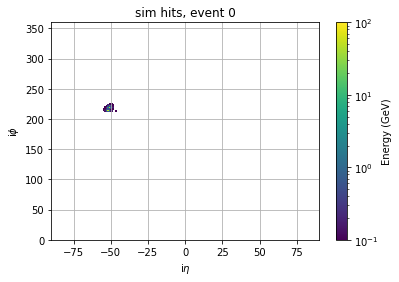

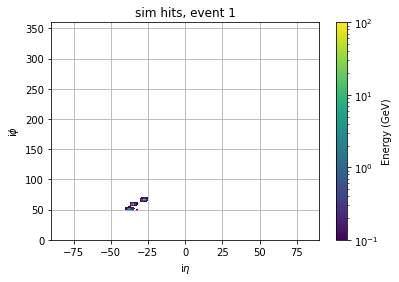

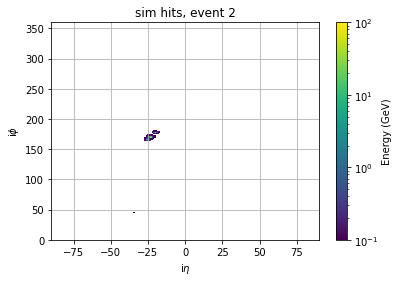

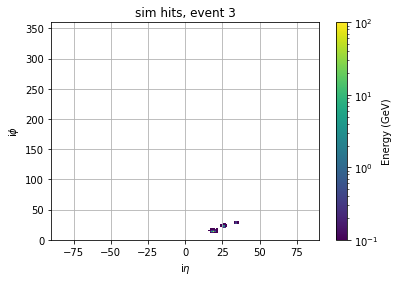

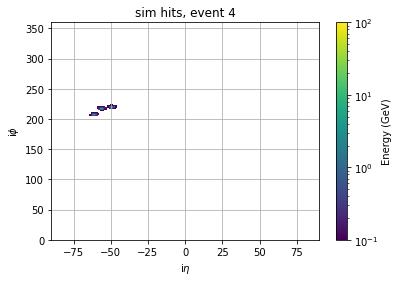

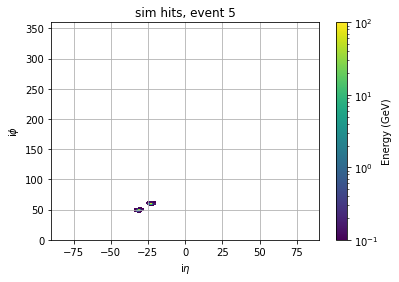

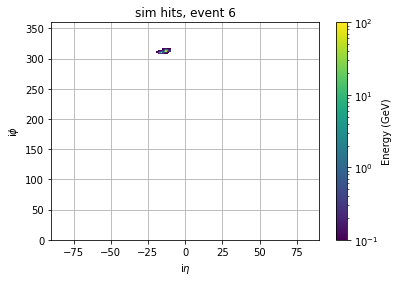

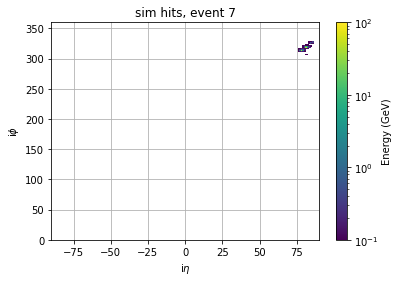

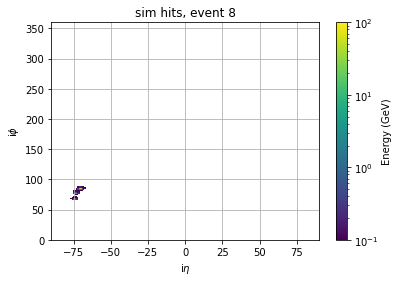

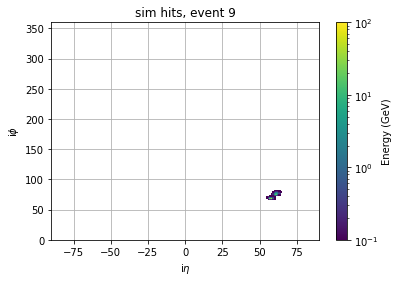

<Figure size 432x288 with 0 Axes>

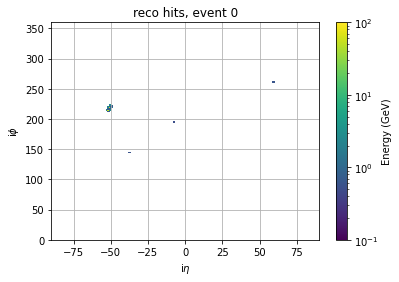

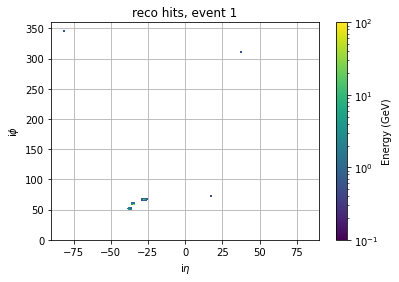

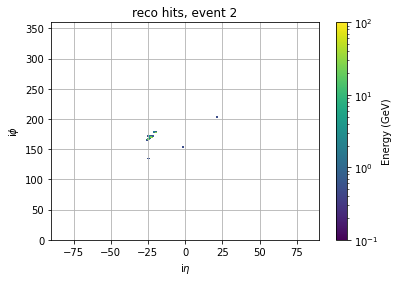

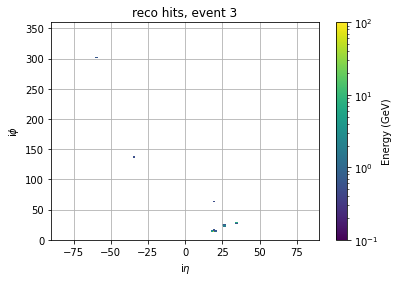

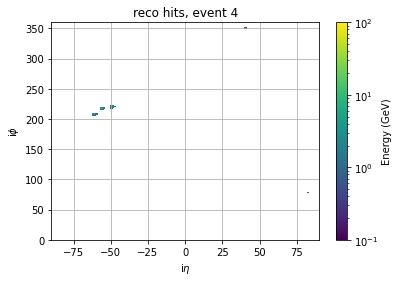

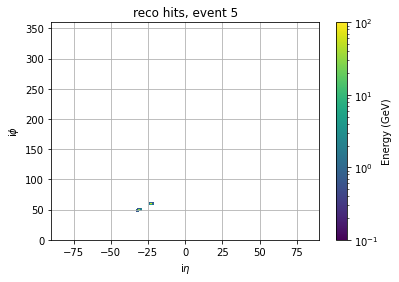

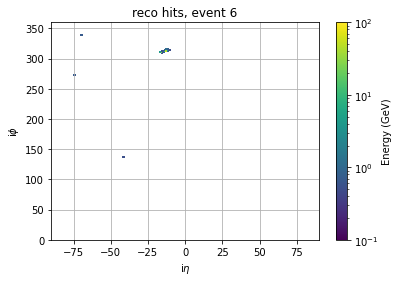

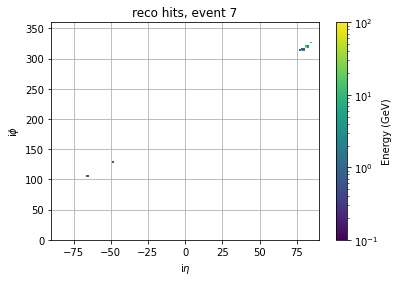

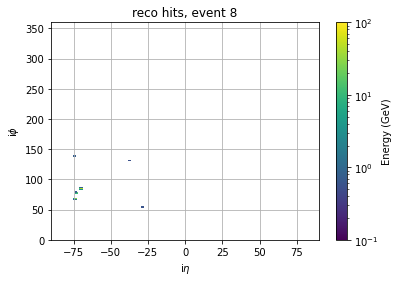

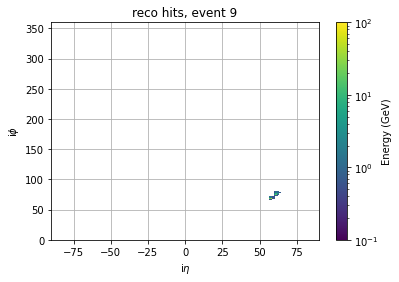

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title  KNN { form-width: "30%" }
# from the list of dataframes remove those where the reco has less than 4-5 rows, depends on the number of neighbours

good_indices = [idf for idf,df in enumerate(recodfs) if len(df.index)> n_neighbours] #list(map(lambda x : len(x.index) > n_neighbours, recodfs))
recodfs = [recodfs[i] for i in good_indices]
simdfs = [simdfs[i] for i in good_indices]

matricesKNN = generateMatricesKNN(recodfs=recodfs, n_neighbours=n_neighbours)  
# => 14.5 s for 10K

# some x,y plotting   => SUPER SLOW, WHY?
if doXYplot: 
  plot_XY(dfs=simdfs, what='sim')
  plot_XY(dfs=recodfs, what='reco')


In [ ]:
#@title   Create the dictionaries  { form-width: "30%" }

# Create the dictionaries for reco and ground truth
#reco_dicts,true_dicts = getDictsFromDFs(recodfs,simdfs,rand,doSelection=True,matricesSel=matricesKNN)
reco_dicts,true_dicts = getDictsFromDFs(recodfs,simdfs,rand,doSelection=True,matricesSel=matricesKNN)

# 0.1 evt/s => ~0.5h for 10K

Info getDictsFromDFs(), event= 0
Info getDictsFromDFs(), event= 10
Info getDictsFromDFs(), event= 20
Info getDictsFromDFs(), event= 30
Info getDictsFromDFs(), event= 40
Info getDictsFromDFs(), event= 50
Info getDictsFromDFs(), event= 60
Info getDictsFromDFs(), event= 70
Info getDictsFromDFs(), event= 80
Info getDictsFromDFs(), event= 90
Info getDictsFromDFs(), event= 100
Info getDictsFromDFs(), event= 110
Info getDictsFromDFs(), event= 120
Info getDictsFromDFs(), event= 130
Info getDictsFromDFs(), event= 140
Info getDictsFromDFs(), event= 150
Info getDictsFromDFs(), event= 160
Info getDictsFromDFs(), event= 170
Info getDictsFromDFs(), event= 180
Info getDictsFromDFs(), event= 190
Info getDictsFromDFs(), event= 200
Info getDictsFromDFs(), event= 210
Info getDictsFromDFs(), event= 220
Info getDictsFromDFs(), event= 230
Info getDictsFromDFs(), event= 240
Info getDictsFromDFs(), event= 250
Info getDictsFromDFs(), event= 260
Info getDictsFromDFs(), event= 270
Info getDictsFromDFs(), event= 

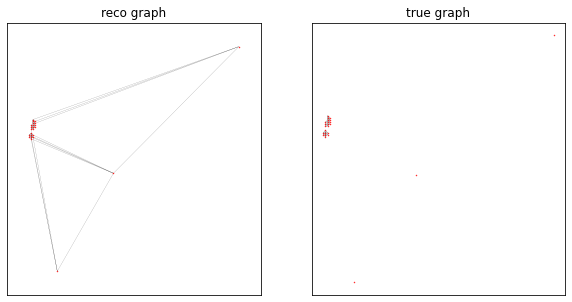

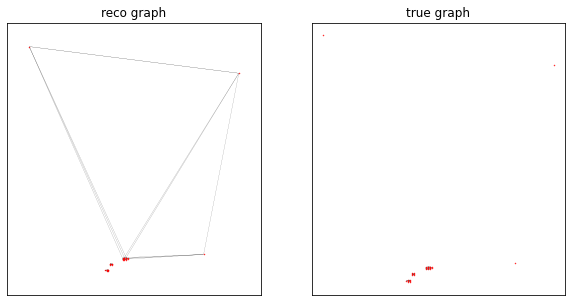

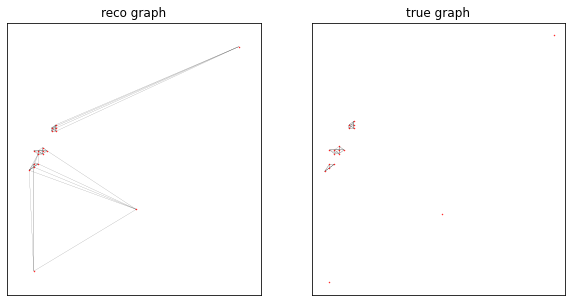

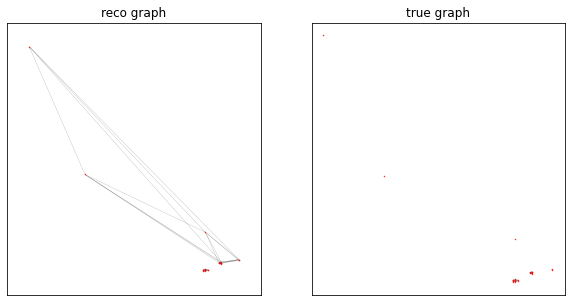

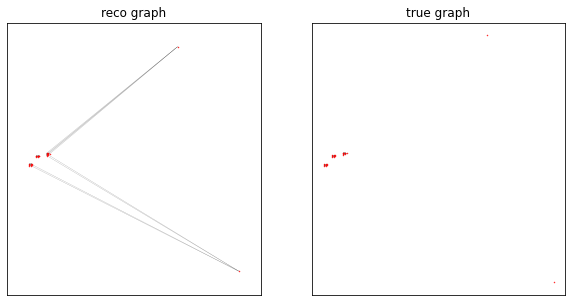

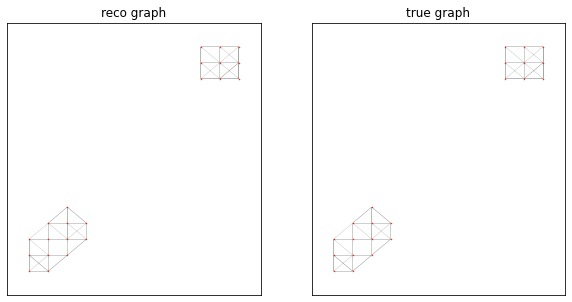

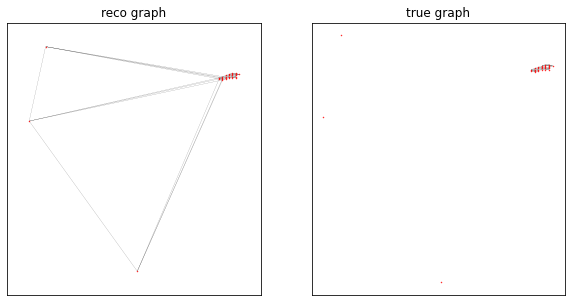

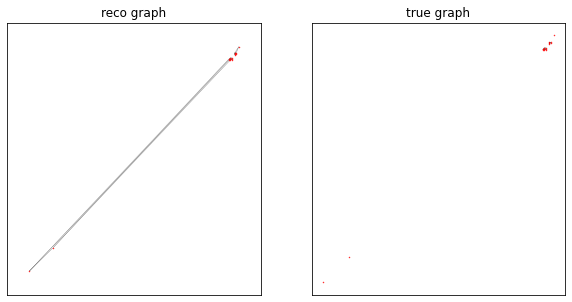

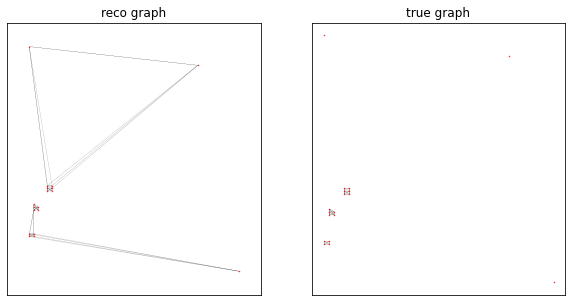

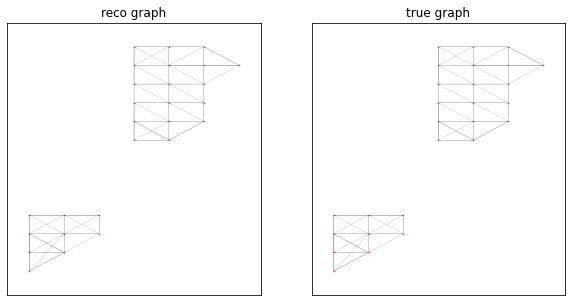

In [ ]:
#@title   Plot example graphs  { form-width: "30%" }
plot_graphs_from_dicts(reco_dicts[:n_max_plots],true_dicts[:n_max_plots])

In [ ]:
#@title   Save the dictionaires to disk { form-width: "30%" }

# Save them to disk
with open('{}/reco_{}.pickle'.format(plotpath, nevts),'wb') as po:
  pickle.dump(reco_dicts, po)
with open('{}/true_{}.pickle'.format(plotpath, nevts),'wb') as po:
  pickle.dump(true_dicts, po)

# Training

In [ ]:
#@title Load dictionaries and split them { form-width: "30%" }
with open('{}/reco_{}.pickle'.format(plotpath, nevts),'rb') as pi:
  reco_dicts = pickle.load(pi)
with open('{}/true_{}.pickle'.format(plotpath, nevts),'rb') as pi:
  true_dicts = pickle.load(pi)

assert(len(reco_dicts)==len(true_dicts))

# split between training and test 
tr_fraction = 0.60
ge_fraction = 1 - tr_fraction


# first indices for training, second for test
# I don't need to randomize, because the generation is already random
tot_examples = len(reco_dicts)
n_tr_examples = int(tot_examples * tr_fraction )
n_ge_examples = tot_examples-n_tr_examples

reco_dicts_tr = reco_dicts[:n_tr_examples]
reco_dicts_ge = reco_dicts[n_tr_examples:]
true_dicts_tr = true_dicts[:n_tr_examples]
true_dicts_ge = true_dicts[n_tr_examples:]

print('Training will have n={} examples'.format(n_tr_examples))
print(' Testing will have n={} examples'.format(n_ge_examples))

#print(true_dicts_ge)

Training will have n=1306 examples
 Testing will have n=872 examples


In [ ]:
#@title Training options and place holder creation  { form-width: "30%" }

tf.reset_default_graph()
  
# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 1
num_processing_steps_ge = 1
 
# Data
# training parameters.
num_training_iterations = 10000
batch_size_tr = 32 # 32
batch_size_ge = 50 # 50 100
if(batch_size_tr>n_tr_examples or batch_size_ge>n_ge_examples):
  raise RuntimeError('Adjust batch sizes, currently\n batch_size_tr={} n_tr_examples={}\n batch_size_ge={} n_ge_examples={}'.format(batch_size_tr, n_tr_examples, batch_size_ge, n_ge_examples))
 
# placeholders 
# note that the placeholder objects do not have a definite size, 
# so we can create the same placeholders for training and test
reco_ph, true_ph = create_placeholders(rand, batch_size_tr, reco_dicts, true_dicts) 

# Model instance
edge_output_size = 2
node_output_size = None if not useNodes else nFrac
global_output_size = None
model = models.EncodeProcessDecode(edge_output_size=edge_output_size, node_output_size=node_output_size) # size of the real space for edges and nodes
# the number of layers for the number of nodes per layer are hard-coded within the library...!

# a list of outputs with size num_processing_steps
output_ops_tr = model(reco_ph, num_processing_steps_tr)
output_ops_ge = model(reco_ph, num_processing_steps_ge)
  
# Training loss.
loss_ops_tr = create_loss_ops(true_ph, output_ops_tr) 
# Average of losses across processing steps
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr
# Test/generalization loss.
loss_ops_ge = create_loss_ops(true_ph, output_ops_ge)
loss_op_ge = loss_ops_ge[-1]  # Loss from final processing step.
    
# Optimizer.
learning_rate = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)    
 
# make them TF runnable
reco_ph, true_ph = make_all_runnable_in_session(reco_ph, true_ph) 
 

 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

loss_ops= [<tf.Tensor 'softmax_cross_entropy_loss/value:0' shape=() dtype=float32>]
loss_ops= [<tf.Tensor 'softmax_cross_entropy_loss_1/value:0' shape=() dtype=float32>]


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
#@title Reset TF session  { form-width: "30%" }
  
# Reset TF session, but keep the same computational graph 
#   graph: defines the computation, does not hold values, only operations
#   session: allows to execute graphs, it allocates resources and holds the values of the variables 
try:
 sess.close()
except NameError:
 pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())
  
last_iteration = 0
logged_iterations = []
losses_tr = []
accs_tr = []
#corrects_tr = []
#solveds_tr = []
losses_ge = []
accs_ge = []
#corrects_ge = []
#solveds_ge = []
last_feed_dict_ge = -1

In [ ]:
#@title Run the training  { form-width: "30%" }
  
#### Run the training
log_every_seconds = 1.9
 
print("# (iteration number), T (elapsed seconds), "
        "Ltr (training loss), Lge (test/generalization loss), "
        "Ctr (training fraction edges labeled correctly), "
        "Cge (test/generalization fraction edges labeled correctly), ")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
  last_iteration = iteration
  feed_dict = create_feed_dict(rand, batch_size_tr, reco_ph, true_ph, reco_dicts_tr, true_dicts_tr) 
  train_values = sess.run(
    {"step": step_op,
     "target": true_ph,
     "loss": loss_op_tr,
     "outputs": output_ops_tr},
     feed_dict=feed_dict
  )
  the_time = time.time()
  elapsed_since_last_log = the_time - last_log_time
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    feed_dict = create_feed_dict(rand, batch_size_ge, reco_ph, true_ph, reco_dicts_ge, true_dicts_ge)
    test_values = sess.run(
      {"target": true_ph,
       "loss": loss_op_ge,
       "outputs": output_ops_ge},
      feed_dict=feed_dict
    )

    last_feed_dict_ge = feed_dict
    acc_tr = compute_accuracy(train_values["target"], train_values["outputs"][-1]) 
    acc_ge = compute_accuracy(test_values["target"], test_values["outputs"][-1])
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    accs_tr.append(acc_tr)
    losses_ge.append(test_values["loss"])
    accs_ge.append(acc_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Acctr {:.4f}, Accge {:.4f}".format(
              iteration, elapsed, train_values["loss"], test_values["loss"],
              acc_tr, acc_ge))
    
    #plotTraining(logged_iterations, losses_tr, losses_ge, accs_tr, accs_ge)



# (iteration number), T (elapsed seconds), Ltr (training loss), Lge (test/generalization loss), Ctr (training fraction edges labeled correctly), Cge (test/generalization fraction edges labeled correctly), 
# 00043, T 2.2, Ltr 0.2708, Lge 0.2892, Acctr 0.8547, Accge 0.8155
# 00116, T 3.8, Ltr 0.0540, Lge 0.0502, Acctr 0.9937, Accge 0.9939
# 00200, T 5.7, Ltr 0.0227, Lge 0.0258, Acctr 0.9964, Accge 0.9968
# 00287, T 7.7, Ltr 0.0155, Lge 0.0244, Acctr 0.9980, Accge 0.9956
# 00364, T 9.6, Ltr 0.0192, Lge 0.0139, Acctr 0.9960, Accge 0.9978
# 00433, T 11.5, Ltr 0.0152, Lge 0.0265, Acctr 0.9974, Accge 0.9943
# 00509, T 13.4, Ltr 0.0141, Lge 0.0224, Acctr 0.9975, Accge 0.9947
# 00585, T 15.3, Ltr 0.0179, Lge 0.0193, Acctr 0.9953, Accge 0.9957
# 00663, T 17.2, Ltr 0.0156, Lge 0.0223, Acctr 0.9956, Accge 0.9941
# 00742, T 19.1, Ltr 0.0187, Lge 0.0184, Acctr 0.9945, Accge 0.9965
# 00826, T 21.0, Ltr 0.0069, Lge 0.0244, Acctr 0.9992, Accge 0.9944
# 00905, T 23.0, Ltr 0.0113, Lge 0.0220, Acctr 0.99

target_graphs_nx= 50
input_graphs_nx= 50
h= 10 w= 4


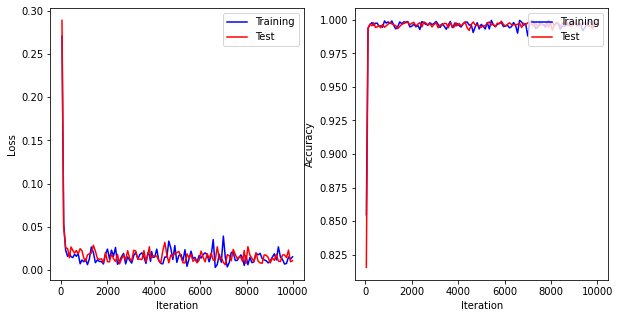

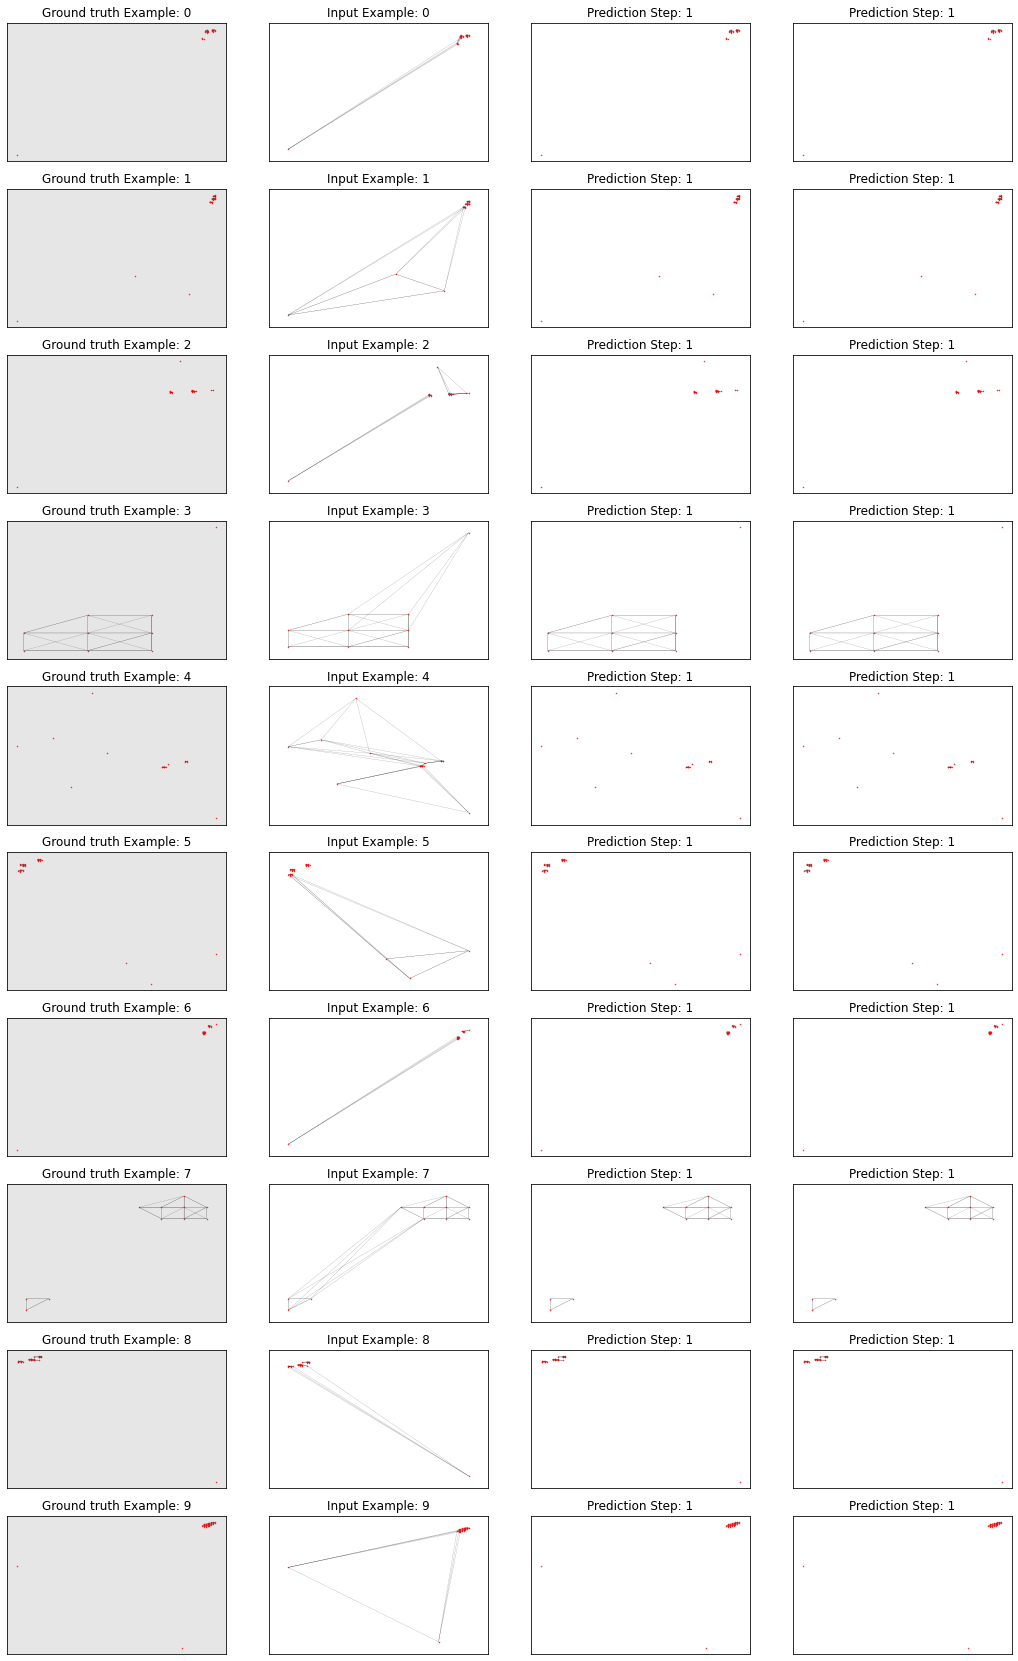

In [ ]:
#@title Visualize results  { form-width: "30%" }

# visualize loss for training and test
#print(logged_iterations, losses_tr, losses_ge, accs_tr, accs_ge)
#print(len(logged_iterations), len(losses_tr), len(losses_ge), len(accs_tr), len(accs_ge))
label='btr{}_bge{}_lr{}_ec{}'.format(batch_size_tr, batch_size_ge, learning_rate, 0.05)

plotTraining(logged_iterations, losses_tr, losses_ge, accs_tr, accs_ge, label=label)

# For a few example in the last test batch
# Plot truth, input and outputs (for different processing steps)
max_graphs_to_plot = 10
num_steps_to_plot = 2


target_graphs = test_values["target"] #utils_np.graphs_tuple_to_data_dicts(test_values["target"])
target_graphs_nx = gn.utils_np.graphs_tuple_to_networkxs(target_graphs)
print('target_graphs_nx=',len(target_graphs_nx))

num_graphs = len(target_graphs_nx) # should be the batch_size_ge
step_indices = np.floor(
    np.linspace(0, num_processing_steps_ge - 1,
                num_steps_to_plot)).astype(int).tolist()
outputs_graphs = [test_values["outputs"][i] for i in step_indices]
outputs_graphs_nx = [gn.utils_np.graphs_tuple_to_networkxs(output_graph) for output_graph in outputs_graphs]

input_graphs = last_feed_dict_ge[reco_ph]
input_graphs_nx = gn.utils_np.graphs_tuple_to_networkxs(input_graphs)
print('input_graphs_nx=',len(input_graphs_nx))


h = min(num_graphs, max_graphs_to_plot)
w = num_steps_to_plot + 2  # add +1 for the input
print('h=', h , 'w=', w)
fig = plt.figure(101, figsize=(18, h * 3))
fig.clf()


for j, target_graph_nx in enumerate(target_graphs_nx):
  if j >= h:
    break

  # Ground truth  
  iax = j * (2 + num_steps_to_plot) + 1 
  #print('iax for truth =',iax)
  ax = fig.add_subplot(h, w, iax)
  pos = plot_graph_nx(target_graph_nx, ax, pos=None, isTruth=True)
  ax.set_title("Ground truth Example: {}".format(j))
  ax.set_axis_on()
  ax.set_xticks([])
  ax.set_yticks([])
  try:
    ax.set_facecolor([0.9] * 3 + [1.0])
  except AttributeError:
    ax.set_axis_bgcolor([0.9] * 3 + [1.0])

  # Input
  iax = j * (2 + num_steps_to_plot) + 2
  #print('iax for input=',iax)
  ax = fig.add_subplot(h, w, iax)
  plot_graph_nx(input_graphs_nx[j], ax, pos=None, isTruth=False, isOutput=False)
  ax.set_title("Input Example: {}".format(j))
  ax.set_axis_on()
  ax.set_xticks([])
  ax.set_yticks([])

  # Prediction
  for step in range(0,len(outputs_graphs_nx)):
    output_graph_nx = outputs_graphs_nx[step][j] 
    iax = j * (2 + num_steps_to_plot) + 3 + step
    #print('iax for output=',iax)
    ax = fig.add_subplot(h, w, iax)
    ax.set_title("Prediction Step: {}".format(step_indices[step] + 1, step_indices[-1] + 1))
    plot_graph_nx(output_graph_nx, ax, pos=pos, isTruth=False, isOutput=True)
    ax.set_axis_on()
    ax.set_xticks([])
    ax.set_yticks([])

fig.savefig('{p}/prst1_results_examples_{l}.png'.format(p=plotpath, l=label))
fig.savefig('{p}/prst1_results_examples_{l}.pdf'.format(p=plotpath, l=label))

#plot_graphs_from_dicts(reco_dicts[:n_max_plots],true_dicts[:n_max_plots])



In [ ]:
#@title (WORK IN PROGRESS) Epochs  { form-width: "30%" }
  
#### Run the training
log_every_epochs = 1
 
print("# (epoch number), T (elapsed seconds), "
        "Ltr (training loss), Lge (test/generalization loss), "
        "Ctr (training fraction edges labeled correctly), "
        "Cge (test/generalization fraction edges labeled correctly), ")

start_time = time.time()
last_log_time = start_time
for epoch in range(last_epoch, num_training_iterations):
  chosen = [] # indices to keep track of data used through one epoch
  last_epoch = epoch
  n_tr_batches = int(n_tr_examples / batch_size) 
  for ibatch in range(0, n_tr_batches):
    choices_tr = 
    #chosen.append()
    feed_dict = create_feed_dict(rand, batch_size_tr, reco_ph, true_ph, reco_dicts_tr, true_dicts_tr) 
    train_values = sess.run(
      {"step": step_op,
       "target": true_ph,
       "loss": loss_op_tr,
       "outputs": output_ops_tr},
      feed_dict=feed_dict
    )
    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    #################
  if elapsed_since_last_log > log_every_seconds:
    last_log_time = the_time
    feed_dict = create_feed_dict(rand, batch_size_ge, reco_ph, true_ph, reco_dicts_ge, true_dicts_ge)
    test_values = sess.run(
      {"target": true_ph,
       "loss": loss_op_ge,
       "outputs": output_ops_ge},
      feed_dict=feed_dict
    )
    acc_tr = compute_accuracy(train_values["target"], train_values["outputs"][-1]) 
    acc_ge = compute_accuracy(test_values["target"], test_values["outputs"][-1])
    elapsed = time.time() - start_time
    losses_tr.append(train_values["loss"])
    accs_tr.append(acc_tr)
    losses_ge.append(test_values["loss"])
    accs_ge.append(acc_ge)
    logged_iterations.append(iteration)
    print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Acctr {:.4f}, Accge {:.4f}".format(
              iteration, elapsed, train_values["loss"], test_values["loss"],
              acc_tr, acc_ge))
    
    #plotTraining(logged_iterations, losses_tr, losses_ge, accs_tr, accs_ge)

